# Tiny Benchmark

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


This notebook is used to test small performance differences in **RxInfer.jl** during the development process for a very simple model. This benchmark does not represent the whole range of possible regressions but it is quick and easy to execute.

In [2]:
using RxInfer, BenchmarkTools, Random, Plots

## Synthetic dataset

In [3]:
seed = 123

rng = MersenneTwister(seed)

v = 100.0

n = 500

hidden     = collect(1:n)
data       = hidden + rand(rng, Normal(0.0, sqrt(v)), n);
datastream = from(data) |> map(NamedTuple{(:y, ), Tuple{Float64}}, (d) -> (y = d, ));

## Filtering

In [9]:
@model function filtering(y, x_prior_mean, x_prior_var, c, v)
    x_prior ~ Normal(mean = x_prior_mean, variance = x_prior_var) 
    x_next ~ x_prior + c
    y ~ Normal(mean = x_next, variance = v)    
end

In [10]:
function run_filtering(datastream, n, v)
    
    autoupdates = @autoupdates begin 
        x_prior_mean, x_prior_var = mean_var(q(x_next))
    end

    init = @initialization begin 
        q(x_next) = NormalMeanVariance(0.0, 10000.0)
    end

    return infer(
        model          = filtering(c = 1.0, v = v),
        datastream     = datastream,
        autoupdates    = autoupdates,
        initialization = init,
        keephistory    = n,
        historyvars    = (x_next = KeepLast(), ),
        free_energy    = true,
        autostart      = true,
        postprocess    = UnpackMarginalPostprocess()
    )
    
end

run_filtering (generic function with 1 method)

In [11]:
result_filtering = run_filtering(datastream, n, v)

RxInferenceEngine:
  Posteriors stream    | enabled for (x_next, x_prior)
  Free Energy stream   | enabled
  Posteriors history   | available for (x_next)
  Free Energy history  | available
  Enabled events       | [  ]

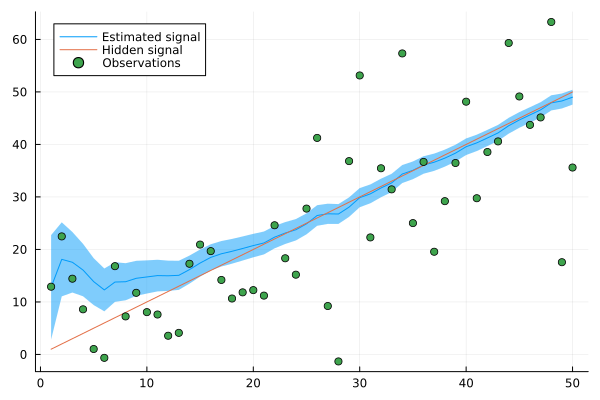

In [12]:
let 
    results = result_filtering.history[:x_next]
    subrange = 1:50
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    
    p = plot()
    
    p = plot!(subrange, m, ribbon = s, label = "Estimated signal")
    p = plot!(subrange, hidden[subrange], label = "Hidden signal")
    p = scatter!(subrange, data[subrange], label = "Observations")
    
    plot(p)
end

## Smoothing

In [13]:
@model function smoothing(y, c, v)
    
    x_prior ~ Normal(mean = 0.0, variance = 10000.0) 
    x_prev = x_prior
    
    for i in eachindex(y)
        x[i] ~ x_prev + c
        y[i] ~ Normal(mean = x[i], variance = v)
        x_prev = x[i]
    end
end

In [14]:
function run_smoothing(data, n, v)
    return infer(
        model = smoothing(c = 1.0, v = v), 
        data  = (y = data, ), 
        returnvars = KeepLast(),
        free_energy = true,
        postprocess = UnpackMarginalPostprocess()
    )
end

run_smoothing (generic function with 1 method)

In [15]:
result_smoothing = run_smoothing(data, n, v)

Inference results:
  Posteriors       | available for (x_prior, x)
  Free Energy:     | Real[1896.23]


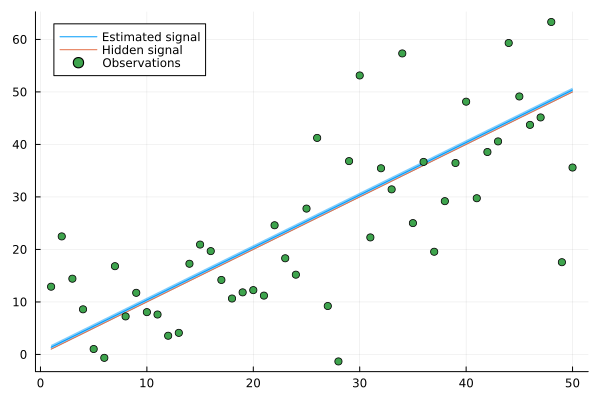

In [16]:
let 
    results = result_smoothing.posteriors[:x]
    subrange = 1:50
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    
    p = plot()
    
    p = plot!(subrange, m, ribbon = s, label = "Estimated signal")
    p = plot!(subrange, hidden[subrange], label = "Hidden signal")
    p = scatter!(subrange, data[subrange], label = "Observations")
    
    plot(p)
end

# Benchmarks

In [17]:
@benchmark run_filtering($datastream, $n, $v)

BenchmarkTools.Trial: 2603 samples with 1 evaluation.
 Range (min … max):  1.746 ms …  12.731 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.825 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.919 ms ± 516.893 μs  ┊ GC (mean ± σ):  3.00% ± 8.32%

  ▇█▇▅▂▁▁                                                     ▁
  ███████▇▇▆▇▆▅▃▃▁▄▃▄▃▃▃▁▁▁▃▃▃▃▁▃▁▁▃▁▄▁▁▁▁▃▃▃▁▃▁▃▁▁▁▁▁▃▃▃▇▇▅▇ █
  1.75 ms      Histogram: log(frequency) by time      4.46 ms <

 Memory estimate: 1.12 MiB, allocs estimate: 32763.

In [18]:
@benchmark run_smoothing($data, $n, $v)

BenchmarkTools.Trial: 163 samples with 1 evaluation.
 Range (min … max):  26.887 ms … 51.531 ms  ┊ GC (min … max): 0.00% … 11.49%
 Time  (median):     29.309 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   30.675 ms ±  4.223 ms  ┊ GC (mean ± σ):  6.87% ±  8.10%

  ▂█▃                                                          
  ███▇▃▄▂▂▄▃▃▁▃▃▅▄▅▂▄▂▂▃▂▄▂▅▃▃▄▄▃▃▁▂▁▁▂▁▁▁▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂ ▂
  26.9 ms         Histogram: frequency by time        44.3 ms <

 Memory estimate: 27.03 MiB, allocs estimate: 657587.